In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine,inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# Use the Inspector to explore the database and print the table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [7]:
# Use Inspector to print the column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    pk = ""
    if c['primary_key'] == 1:
        pk = "Primary Key"
    print(c["name"], c["type"], pk)

id INTEGER Primary Key
station TEXT 
date TEXT 
prcp FLOAT 
tobs FLOAT 


In [8]:
# Use `engine.execute` to select and display the first 10 rows from the measurement table
engine.execute('SELECT * FROM measurement ORDER BY date DESC LIMIT 10 ').fetchall()

[(2724, 'USC00519397', '2017-08-23', 0.0, 81.0),
 (7635, 'USC00514830', '2017-08-23', 0.0, 82.0),
 (12187, 'USC00519523', '2017-08-23', 0.08, 82.0),
 (19550, 'USC00516128', '2017-08-23', 0.45, 76.0),
 (2723, 'USC00519397', '2017-08-22', 0.0, 82.0),
 (12186, 'USC00519523', '2017-08-22', 0.0, 82.0),
 (19549, 'USC00516128', '2017-08-22', 0.5, 76.0),
 (2722, 'USC00519397', '2017-08-21', 0.0, 81.0),
 (7634, 'USC00514830', '2017-08-21', 0.02, 79.0),
 (12185, 'USC00519523', '2017-08-21', None, 82.0)]

In [9]:
# Use Inspector to print the primary key, column names and types
    
columns = inspector.get_columns('station')
for c in columns:
    pk = ""
    if c['primary_key'] == 1:
        pk = "Primary Key"
    print(c["name"], c["type"], pk)


id INTEGER Primary Key
station TEXT 
name TEXT 
latitude FLOAT 
longitude FLOAT 
elevation FLOAT 


In [10]:
# Use `engine.execute` to select and display the first 10 rows from the station table
engine.execute('SELECT * FROM station').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [11]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [12]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [13]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [14]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

 Last Date:  2017-08-23
Query Date:  2016-08-23


Text(0, 0.5, 'Inches')

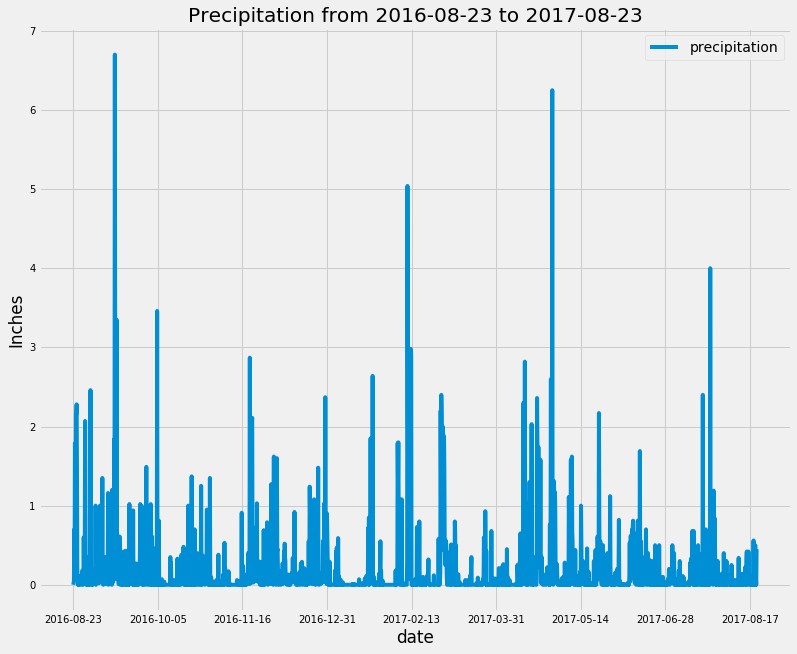

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Get Last Date from measurement table
last_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(" Last Date: ",last_date[0])

# Calculate the date 1 year ago from the last data point in the database
latest_date = dt.datetime.strptime(last_date[0], '%Y-%m-%d')
query_date = dt.date(latest_date.year -1, latest_date.month, latest_date.day)
print("Query Date: ", query_date)

# Perform a query to retrieve the date and precipitation scores
results =session.query(Measurement.date,Measurement.prcp ).\
    filter(Measurement.date >= query_date).all()

# Save the query results as a Pandas DataFrame and drop null values and set the index to the date column
Perc_df = pd.DataFrame(results, columns=['date','precipitation'])
Perc_df = Perc_df.dropna(how='any') 
Perc_df = Perc_df.set_index("date")

# Sort the dataframe by date
Perc_df = Perc_df.sort_values(["date"], ascending=True)
Perc_df.head()

# Use Pandas Plotting with Matplotlib to plot the data
Perc_df.plot(kind='line',figsize=(12,10),stacked=True,fontsize=10)
plt.title(f"Precipitation from {query_date} to {last_date[0]}")
plt.ylabel("Inches")

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
Perc_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [17]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.station).count()

9

In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel = [Measurement.station,func.count(Measurement.id)]
active_stations = session.query(*sel).group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()

active_stations



[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [Measurement.station,func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]
temp_records=session .query(*sel).group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).first()

temp_records

('USC00519281', 54.0, 85.0, 71.66378066378067)

Text(0.5, 1.0, 'Temperature data for USC00519281')

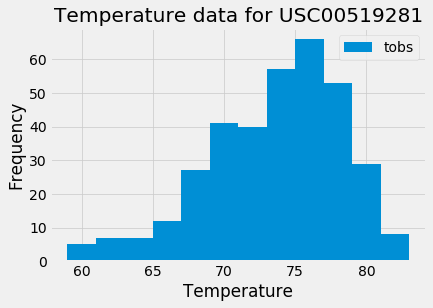

In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
Station_name= active_stations[0][0]
results_1 = session.query(Measurement.tobs).\
    filter(Measurement.station == Station_name).\
    filter(Measurement.date >= query_date).all()
Sation_temp = list(np.ravel(results_1))


#Plot histogram
plt.hist(Sation_temp, bins=12,rwidth=1.0,label='tobs')
plt.grid(axis='both', alpha=0.75)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.title(f"Temperature data for {Station_name}")

## Bonus Challenge Assignment

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = '2017-01-01'
end_date = '2017-01-07'
temp_stat = calc_temps(start_date,end_date)[0]
temp_stat


(62.0, 68.36585365853658, 74.0)

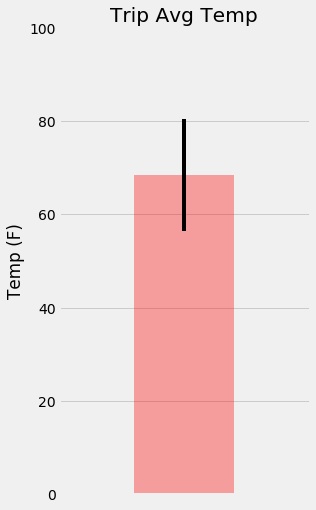

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
x= [0]
y = [temp_stat[1]]
y_error = [(temp_stat[2] - temp_stat[0])]


plt.figure(figsize=(4, 8))
plt.bar(x,y,color='red',alpha=0.35, yerr=y_error)
plt.xlim(-1,1)
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.ylim(0, 100)
plt.tick_params(axis='x',labelbottom=False)
plt.grid(axis='x', which='major',  linestyle='')
plt.grid(axis='y', which='major',  linestyle='-')
plt.show()


In [24]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel = [Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp)]
perc_results=session.query(*sel).\
    filter(Station.station == Measurement.station).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()
    
station_details = pd.DataFrame(perc_results, columns=['Station','Name','Latitude','Longitude','Elevation','Percipitation'])
station_details


,Station,Name,Latitude,Longitude,Elevation,Percipitation
0,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.61
1,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.60
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.60
3,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.35
4,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.20
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.00


In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [26]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
trip_startdate = dt.datetime.strptime('2018-01-01','%Y-%m-%d')
trip_enddate = dt.datetime.strptime('2018-01-07','%Y-%m-%d')

# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date
trip_dates = []
normals =[]
while (trip_startdate <= trip_enddate):
    trip_dates.append(dt.datetime.strftime(trip_startdate,'%Y-%m-%d'))
    date_string = dt.datetime.strftime(trip_startdate,'%m-%d')
    normals.append(list(np.ravel(daily_normals(date_string))))
    trip_startdate = trip_startdate + dt.timedelta(days = 1)

trip_dates
normals



[[62.0, 69.15384615384616, 77.0],
 [60.0, 69.39622641509433, 77.0],
 [62.0, 68.9090909090909, 77.0],
 [58.0, 70.0, 76.0],
 [56.0, 67.96428571428571, 76.0],
 [61.0, 68.96491228070175, 76.0],
 [57.0, 68.54385964912281, 76.0]]

In [27]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
Vacay_df = pd.DataFrame(normals, columns=['Tmin','Tavg','Tmax'])
Vacay_df['Date'] = trip_dates
Vacay_df = Vacay_df.set_index("Date")
Vacay_df


,Tmin,Tavg,Tmax
Date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0
2018-01-06,61.0,68.964912,76.0
2018-01-07,57.0,68.543860,76.0


Text(0, 0.5, 'Temperature')

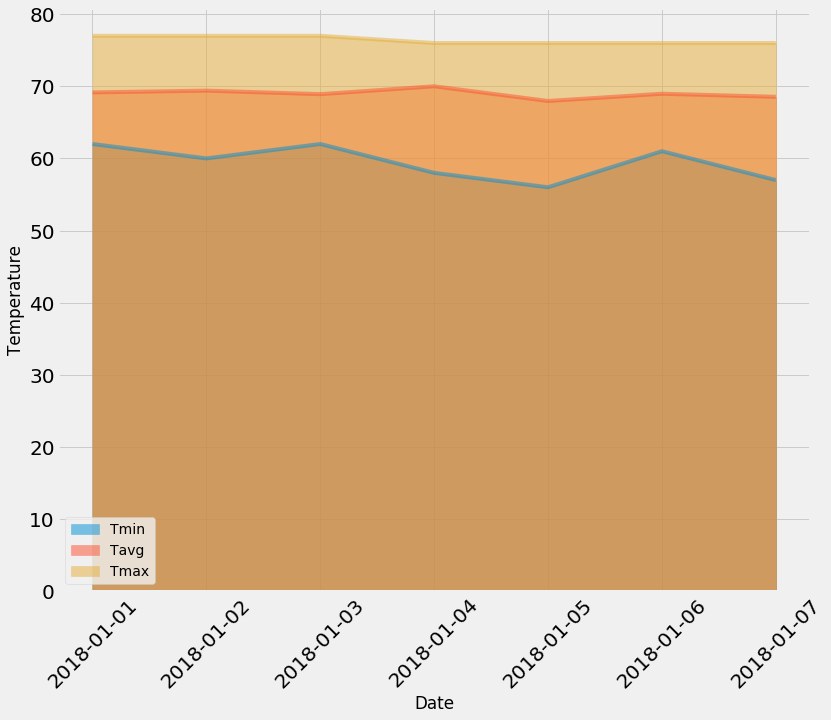

In [28]:
# Plot the daily normals as an area plot with `stacked=False`
Vacay_df.plot(kind='area',figsize=(12,10),stacked=False,fontsize=20)
plt.xticks(rotation=45)
plt.ylabel("Temperature")